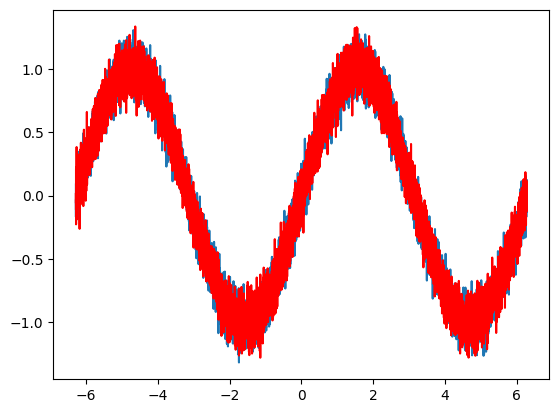

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def f():
    return lambda x: np.sin(x) + 0.1*np.random.randn(len(x))

# plot any function with beautiful style
def plot_function(f, x_min=-2*np.pi, x_max=2*np.pi, n_points=10000, predicted=None):
    x = np.linspace(x_min, x_max, n_points)
    y = f(x)
    plt.plot(x, y)
    if predicted is not None:
        predicted = predicted(x)
        plt.plot(x, predicted, label='Predicted', color='red')
    plt.show()

#plot_function(lambda x: np.sin(x) * np.cos(2*x)/2*np.sin(x))
#plot_function(lambda x: np.sin(x) + 0.1*np.random.randn(len(x)))
plot_function(f(), predicted=lambda x: np.sin(x) + 0.1*np.random.randn(len(x)))

In [65]:
import pennylane as qml

n_ansatz_layers = 1
n_qubits = 3
r = 3

dev = 

@qml.qnode(qml.device('default.qubit', wires=r))
def ansatz(weights):
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return qml.expval(qml.Identity(wires=0))

weights_ansatz = 2 * np.pi * np.random.random(size=(n_ansatz_layers, n_qubits, 3))
#print(qml.draw(ansatz, expansion_strategy="device")(weights_ansatz))

scaling = 1

def S(x):
    """Data-encoding circuit block."""
    for w in range(r):
        qml.RX(scaling * x, wires=w)

def W(theta):
    """Trainable circuit block."""
    qml.StronglyEntanglingLayers(theta, wires=range(r))


@qml.qnode(dev)
def parallel_quantum_model(weights, x):

    W(weights[0])
    S(x)
    W(weights[1])

    return qml.expval(qml.PauliZ(wires=0))

print(qml.draw(parallel_quantum_model, expansion_strategy="device")(weights_ansatz))

ValueError: Weights tensor must have second dimension of length 5; got 3

In [33]:
def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss += (t - p) ** 2
    loss = loss / len(targets)
    return 0.5*loss



4